Data timespan: 2017-10-07 23:00:00 to 2021-03-18 00:00:00
Total records: 30143
Data frequency: 0 days 01:00:00

NaN counts in features:
forecast_demand: 0 NaNs
Temperature: 0 NaNs
Humidity: 0 NaNs
Wind_speed: 0 NaNs
Rain: 0 NaNs
forecast_error_lag24h: 24 NaNs
Shape after dropping NaN values: (30119, 8)

Model Performance:
- MSE: 51395.334
- MAPE: 2.095%

Original Forecast Performance:
- MSE: 55152.352
- MAPE: 2.179%

Improvement Over Original Forecast:
- MSE: 6.812%
- MAPE: 3.858%

Feature Importance:
                 Feature  Importance
0        forecast_demand    0.986969
5  forecast_error_lag24h    0.006443
1            Temperature    0.001943
2               Humidity    0.001863
3             Wind_speed    0.001812
4                   Rain    0.000969


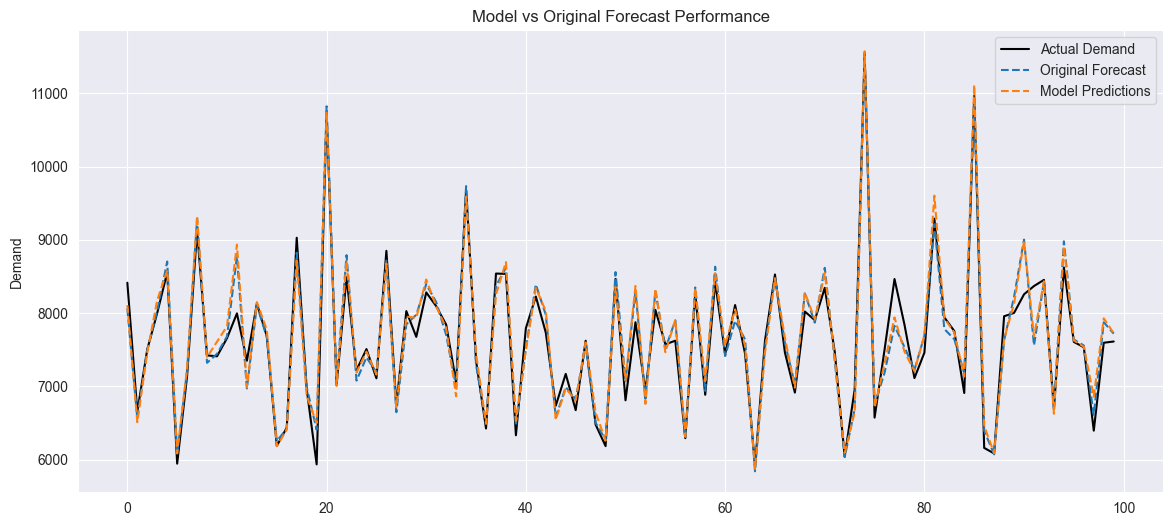

Results saved to demand_forecast_results.csv


In [12]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = r"C:\Users\waseem\Downloads\combined_data_new.csv"  # change path
df = pd.read_csv(file_path)


# Convert to datetime
df["date_time_current_rounded"] = pd.to_datetime(df["date_time_current_rounded"])
df["date_time_future"] = pd.to_datetime(df["date_time_future"])

# Filter for PERIODID 24 and sort
df_sliced = df[df["period_id"] == 24].copy()
df_sliced = df_sliced.sort_values("date_time_future")
df_sliced = df_sliced.dropna()

# Basic dataset info
print(f"Data timespan: {df_sliced['date_time_future'].min()} to {df_sliced['date_time_future'].max()}")
print(f"Total records: {len(df_sliced)}")
print(f"Data frequency: {df_sliced['date_time_future'].diff().value_counts().index[0]}")



# Get forecast error
df_sliced['forecast_error'] = df_sliced['total_demand'] - df_sliced['forecast_demand']
df_sliced['forecast_error_lag24h'] = df_sliced.sort_values('date_time_current_rounded')['forecast_error'].shift(24)



# Define features that would be available at prediction time (12 hours ahead)
features = [
    'forecast_demand',
    'Temperature',
    'Humidity',
    'Wind_speed',
    'Rain',
    'forecast_error_lag24h'
]


# Define target
target = 'total_demand'


# Print the number of NaN values for each feature
print("\nNaN counts in features:")
for feature in features:
    print(f"{feature}: {df_sliced[feature].isna().sum()} NaNs")

# Create the modeling dataframe
model_df = df_sliced[features + [target] + ['date_time_future'] ].copy()
# Drop rows with NaN values
model_df = model_df.dropna()
print(f"Shape after dropping NaN values: {model_df.shape}")


# Split data temporally - using 70-30 split
X = model_df[features]
y = model_df[target]
train_size = 0.7
split_idx = int(len(model_df) * train_size)

# Split into train/test
X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]


# Train model
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_original = X_test["forecast_demand"]

# Evaluate performance
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(0.001, y_true))) * 100
    return mse, mape

# Model metrics
model_mse, model_mape = calculate_metrics(y_test, y_pred)

# Original forecast metrics
original_mse, original_mape = calculate_metrics(y_test, y_pred_original)

# Print formatted results
print("\nModel Performance:")
print(f"- MSE: {model_mse:.3f}")
print(f"- MAPE: {model_mape:.3f}%")

print("\nOriginal Forecast Performance:")
print(f"- MSE: {original_mse:.3f}")
print(f"- MAPE: {original_mape:.3f}%")

# Calculate improvement percentages
improvement_mse = (1 - model_mse/original_mse) * 100
improvement_mape = (1 - model_mape/original_mape) * 100

print("\nImprovement Over Original Forecast:")
print(f"- MSE: {improvement_mse:.3f}%")
print(f"- MAPE: {improvement_mape:.3f}%")

# Feature importance
feature_importance = pd.DataFrame(
    {'Feature': features,
     'Importance': model.feature_importances_}
).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot a sample of 100 data points
sample = np.random.choice(len(y_test), 100, replace=False)
x_axis = range(len(sample))

plt.figure(figsize=(14, 6))
sns.lineplot(x=x_axis, y=y_test.iloc[sample], label='Actual Demand', color='black')
sns.lineplot(x=x_axis, y=y_pred_original.iloc[sample], label='Original Forecast', linestyle='--')
sns.lineplot(x=x_axis, y=y_pred[sample], label='Model Predictions', linestyle='--')
plt.title("Model vs Original Forecast Performance")
plt.ylabel("Demand")
plt.show()

# Create a DataFrame with the prediction results
results_df = pd.DataFrame({
    'date_time_future': model_df['date_time_future'].iloc[split_idx:].values,  # Using test set dates
    'total_demand': y_test.values,
    'forecast_demand': y_pred_original,
    'model_prediction': y_pred
})

# Save to CSV
output_path = "demand_forecast_results.csv"
results_df.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")